In [1]:
# !pip install --upgrade pip
# !pip install numpy --upgrade
# !pip install tensorflow pillow matplotlib


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-05-21 13:32:22.268928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 13:32:22.270945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 13:32:22.275689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 13:32:22.289863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747834342.337953   10727 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747834342.35

In [18]:
import os
import pathlib

if not os.path.exists("flower_photos"):
    !wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
    !tar -xvzf flower_photos.tgz

data_dir = pathlib.Path("flower_photos")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


In [19]:
len(list(data_dir.glob('roses/*')))

641

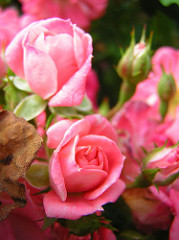

In [20]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[451]))

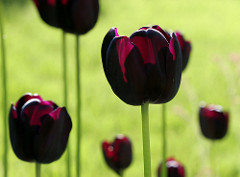

In [21]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[10]))

In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [23]:
help(tf.keras.utils.image_dataset_from_directory)

Help on function image_dataset_from_directory in module keras.src.utils.image_dataset_utils:

image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)
    Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:

    ```
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
    ```

    Then calling `image_dataset_from_directory(main_directory,
    labels='inferred')` will return a `tf.data.Dataset` that yields batches of
    images from the subdirectories `class_a` and `class_b`, together with labels
    0 and 1 (0 corresponding to `class_a` and 1 corresponding to `cl

In [24]:
# Loads images from a directory and assign labels based on the sub-director name
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2025-05-21 13:40:38.426914: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


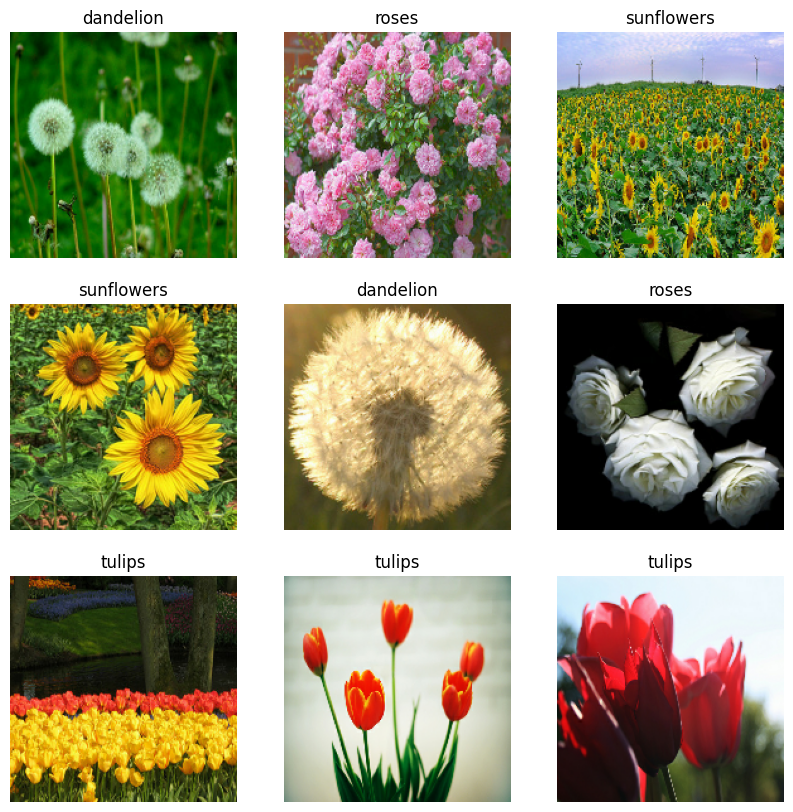

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
normalization_layer = layers.Rescaling(1./255)

In [33]:
# Take each image (x) and its corresponding label (y) from the dataset, 
# Applies the normalization layer to the image, 
# and then returns the normalized image along with its label.
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Retrieve a single batch of images and their corresponding labels 
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [34]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs=10
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                    )

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.3786 - loss: 1.4884 - val_accuracy: 0.5627 - val_loss: 1.0724
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.5861 - loss: 1.0268 - val_accuracy: 0.5954 - val_loss: 1.0072
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.6608 - loss: 0.8944 - val_accuracy: 0.6253 - val_loss: 0.9052
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.7707 - loss: 0.6479 - val_accuracy: 0.6117 - val_loss: 1.0058
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.8292 - loss: 0.4707 - val_accuracy: 0.6308 - val_loss: 1.1080
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - accuracy: 0.9139 - loss: 0.2721 - val_accuracy: 0.6594 - val_loss: 1.0723
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.9588 - loss: 0.1405 - val_accuracy: 0.6199 - val_loss: 1.4122
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step - accuracy: 0.9840 - loss: 0.0676 - val_accu

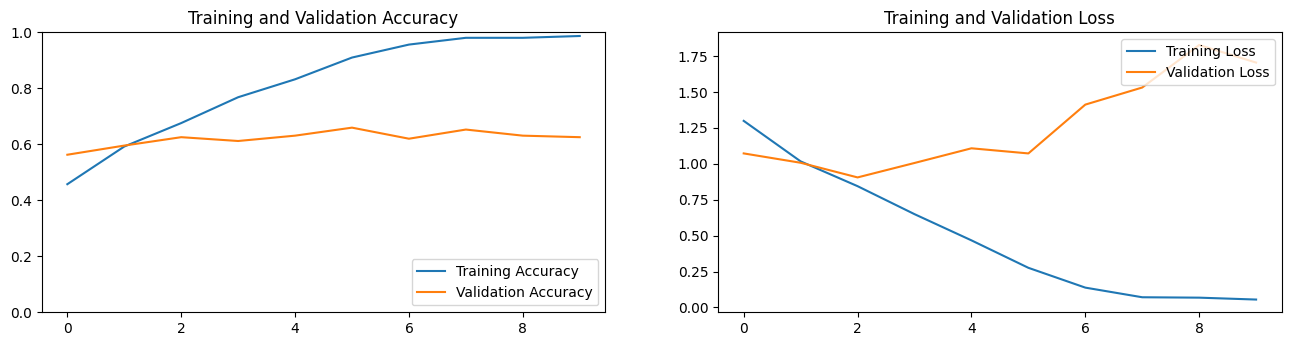

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.ylim(0,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2025-05-21 13:52:32.581545: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


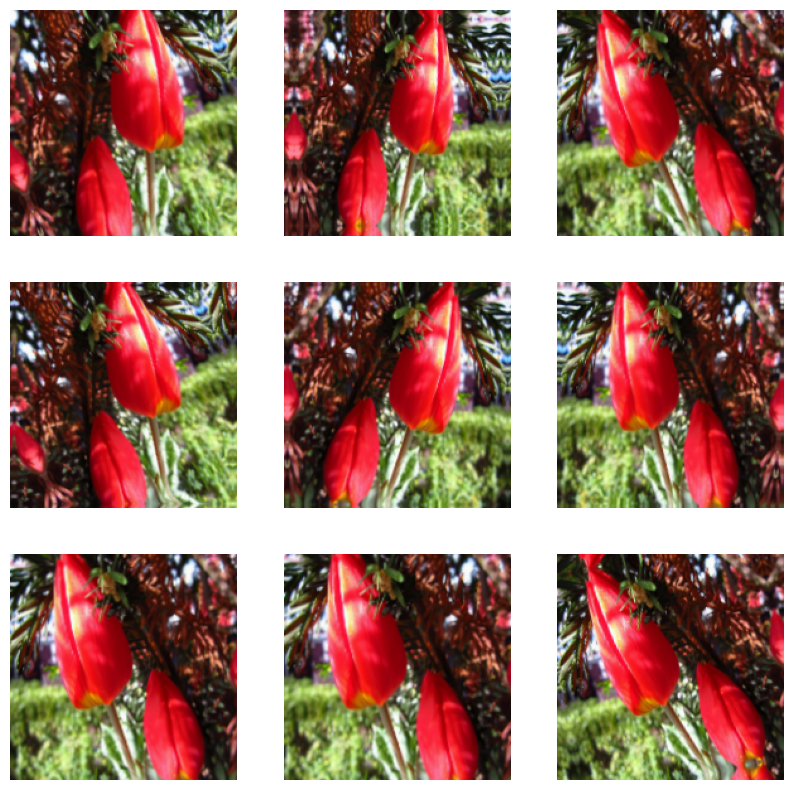

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [43]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 429ms/step - accuracy: 0.3437 - loss: 1.6085 - val_accuracy: 0.4946 - val_loss: 1.1336
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 687ms/step - accuracy: 0.5772 - loss: 1.0552 - val_accuracy: 0.6144 - val_loss: 1.0744
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.6181 - loss: 0.9793 - val_accuracy: 0.6213 - val_loss: 0.9580
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.6530 - loss: 0.9011 - val_accuracy: 0.6431 - val_loss: 0.9597
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.6829 - loss: 0.8412 - val_accuracy: 0.6717 - val_loss: 0.8907
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 485ms/step - accuracy: 0.6889 - loss: 0.8140 - val_accuracy: 0.6444 - val_loss: 0.9212
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.6979 - loss: 0.7691 - val_accuracy: 0.6894 - val_loss: 0.8051
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - accuracy: 0.7424 - loss: 0.6890 - val_accu

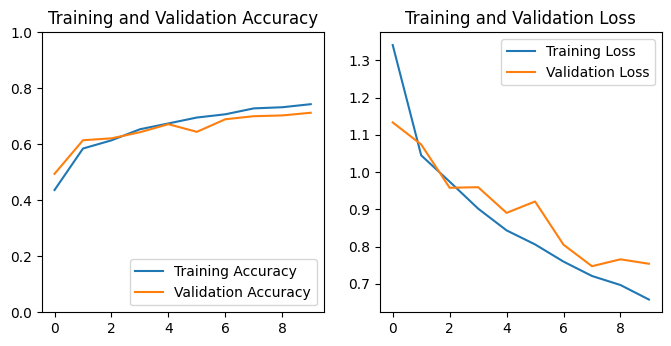

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.ylim(0,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

PIL.Image.open(sunflower_path)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

print(predictions)

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[-6.6507254  -1.3776301   0.62954646  7.44087     4.3510118 ]]
This image most likely belongs to sunflowers with a 95.53 percent confidence.


In [49]:
print(score)
print(sum(score))
print(np.argmax(score))

tf.Tensor([7.2485602e-07 1.4136043e-04 1.0520429e-03 9.5533037e-01 4.3475576e-02], shape=(5,), dtype=float32)
tf.Tensor(1.0000001, shape=(), dtype=float32)
3


In [50]:
predictions
score

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([7.2485602e-07, 1.4136043e-04, 1.0520429e-03, 9.5533037e-01,
       4.3475576e-02], dtype=float32)>

In [52]:
np.argmax(score)    

np.int64(3)

In [53]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [54]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4tg_mu60/assets


INFO:tensorflow:Assets written to: /tmp/tmp4tg_mu60/assets


Saved artifact at '/tmp/tmp4tg_mu60'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  124480240009040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240005200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480239999056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240008464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240006352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240008848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240000976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240008272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480240007312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124480239999632: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1747836148.656740   10727 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747836148.656785   10727 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-21 14:02:28.657296: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4tg_mu60
2025-05-21 14:02:28.658852: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-21 14:02:28.658869: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp4tg_mu60
I0000 00:00:1747836148.663880   10727 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-05-21 14:02:28.664841: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-21 14:02:28.716392: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp4tg_mu60
2025-05-21 14:02:28.726770: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 